# Time Series Analysis and Forecast

In [126]:
import pandas as pd 
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [127]:
data = yf.download("^GSPC", start="2010-01-01", end=dt.datetime.today())
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2023-07-28,4565.750000,4590.160156,4564.009766,4582.229980,4582.229980,3981010000
2023-07-31,4584.819824,4594.220215,4573.140137,4588.959961,4588.959961,4503600000
2023-08-01,4578.830078,4584.620117,4567.529785,4576.729980,4576.729980,4042370000


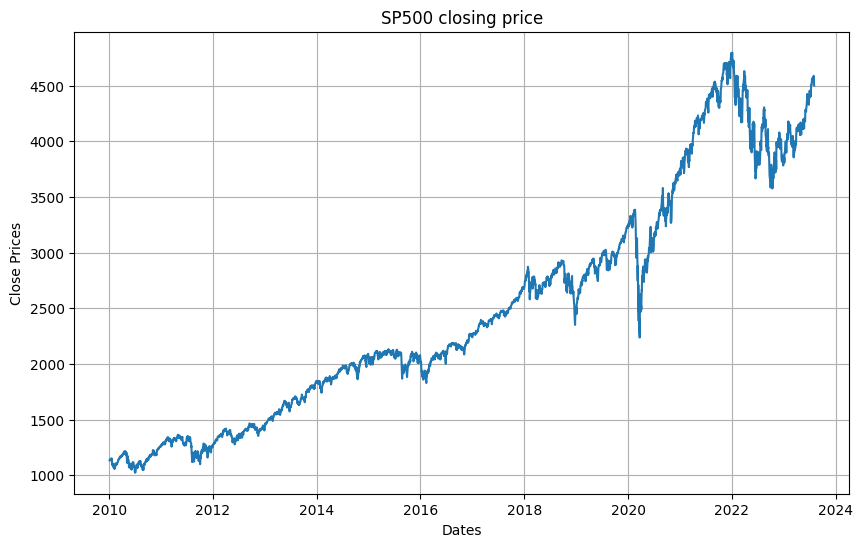

In [128]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('SP500 closing price')
plt.show()

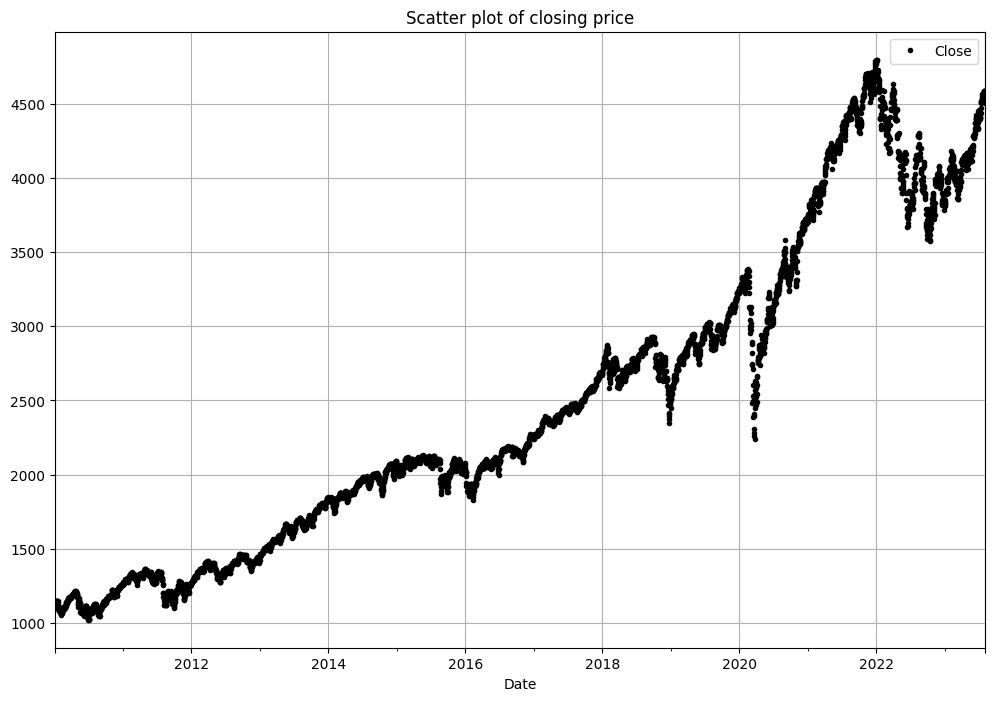

In [129]:
df_close = pd.DataFrame(data['Close'])
df_close = df_close.asfreq('d')
df_close.interpolate(method='linear', inplace=True)
df_close.plot(style="k.", figsize=(12, 8), grid=True)
plt.title('Scatter plot of closing price')
plt.show()

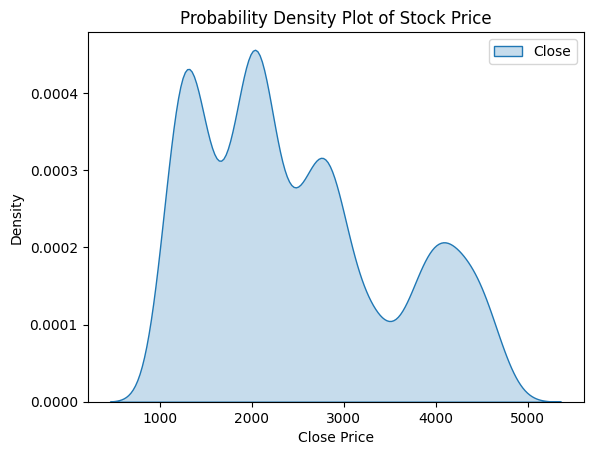

In [130]:
sns.kdeplot(df_close, fill=True);
# Set plot labels and title
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.title('Probability Density Plot of Stock Price')

# Show the plot
plt.show()

## Stationarity and ADF (Augmented Dickey-Fuller) Test

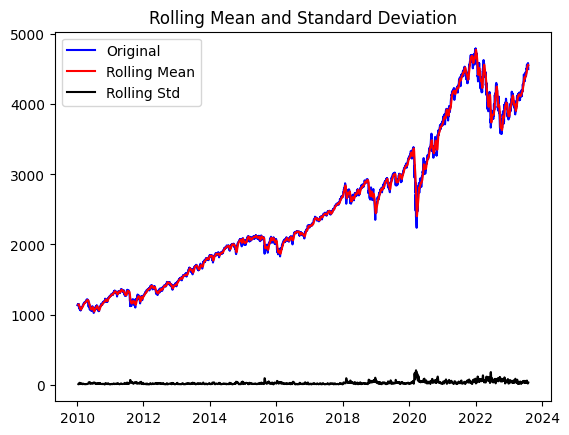

Results of dickey fuller test
Test Statistics                  -0.106154
p-value                           0.948822
No. of lags used                 21.000000
Number of observations used    4938.000000
critical value (1%)              -3.431675
critical value (5%)              -2.862125
critical value (10%)             -2.567082
dtype: float64


In [131]:
# Null Hypothesis: The series has a unit root (value of a =1)
# Alternate Hypothesis: The series has no unit root (it is stationary)
# If we fail to reject the null hypothesis, we can say that the series is non-stationary.
# Moreover if both mean and  standard deviation are constant over time the series is stationary.

#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)


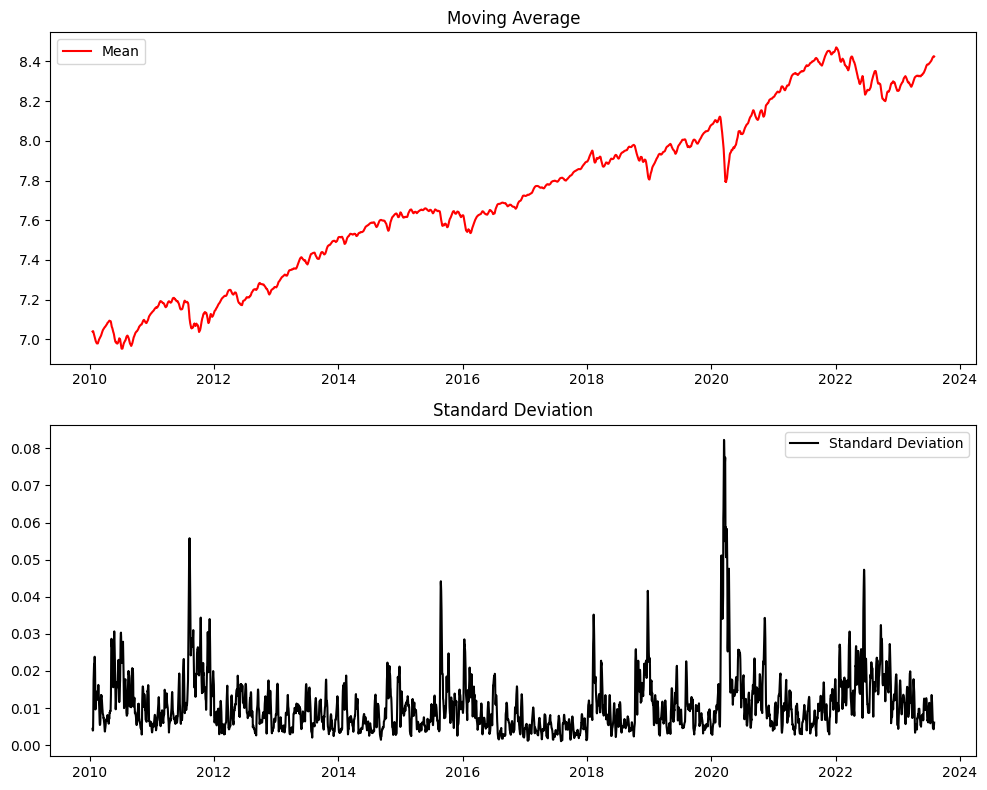

In [132]:
df_log = np.log(df_close)
moving_avg = df_log.rolling(14).mean()
std_dev = df_log.rolling(14).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Moving Average on the first subplot
ax1.plot(moving_avg, color="red", label="Mean")
ax1.legend()
ax1.set_title('Moving Average')

# Plot Standard Deviation on the second subplot
ax2.plot(std_dev, color="black", label="Standard Deviation")
ax2.legend()
ax2.set_title('Standard Deviation')

plt.tight_layout()
plt.show()

## Time series decomposition

<Figure size 640x480 with 0 Axes>

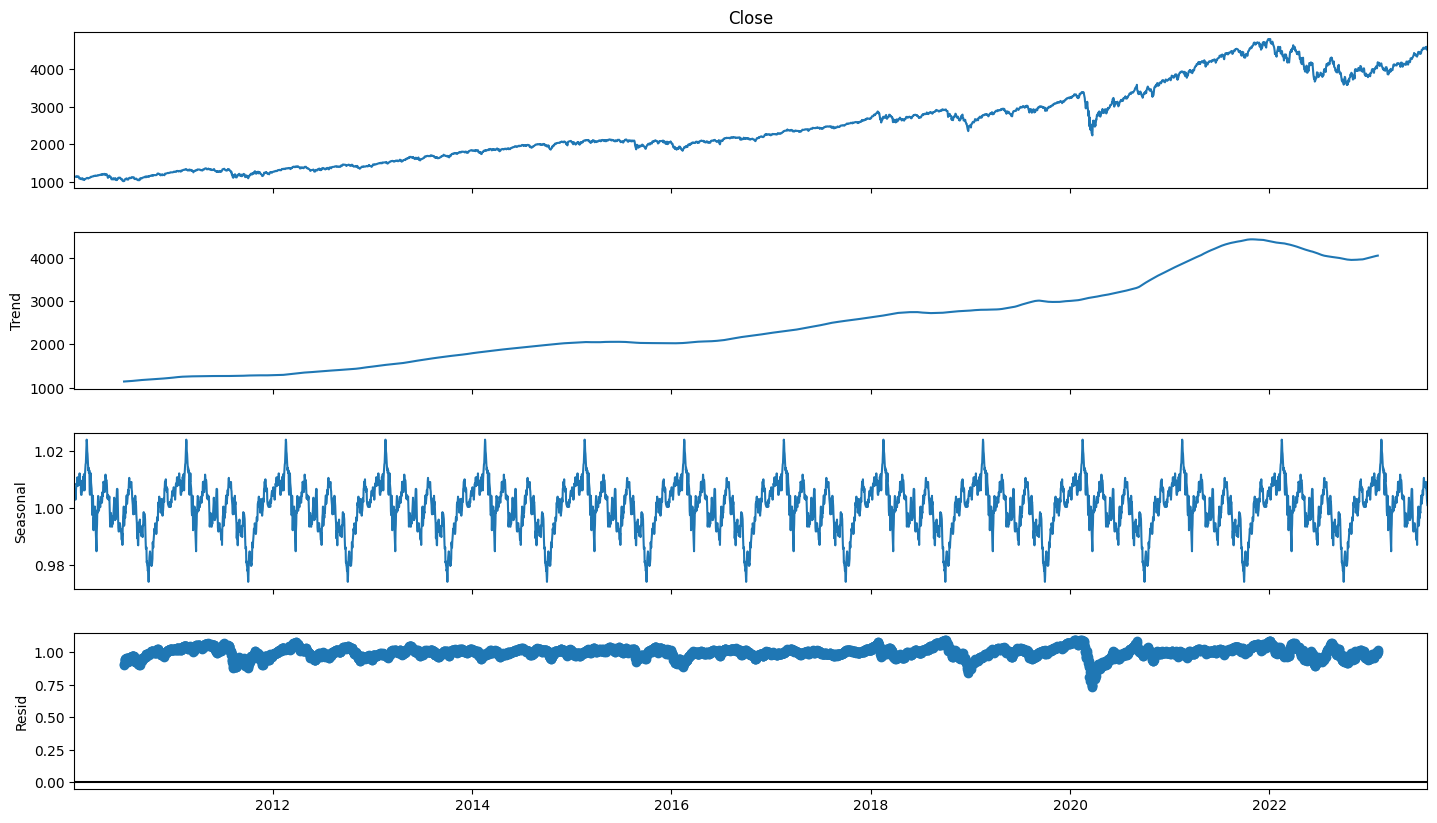

In [133]:
"""
Time series -> combination of level (average value in the series), trend (increasing or decreasing value in the series), 
               seasonality (repeating short-term cycle in the series), and noise (random variation in the series) components.
Time series decomposition -> separate these components to get a better understanding of the data.
All series have a level and noise. The trend and seasonality components are optional.
The components are combined either additively or multiplicatively.
Additive decomposition -> value = level + trend + seasonality + noise
Multiplicative decomposition -> value = level * trend * seasonality * noise
It is better to use additive decomposition when the magnitude of the seasonal fluctuations or the variation around the trend-cycle do not vary with the level of the time series.
It is better to use multiplicative decomposition when the magnitude of the seasonal fluctuations or the variation around the trend-cycle do vary with the level of the time series.
"""
df_c = pd.Series(df_close.Close, index=df_close.index)
result = seasonal_decompose(df_c, model='multiplicative', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

<Figure size 640x480 with 0 Axes>

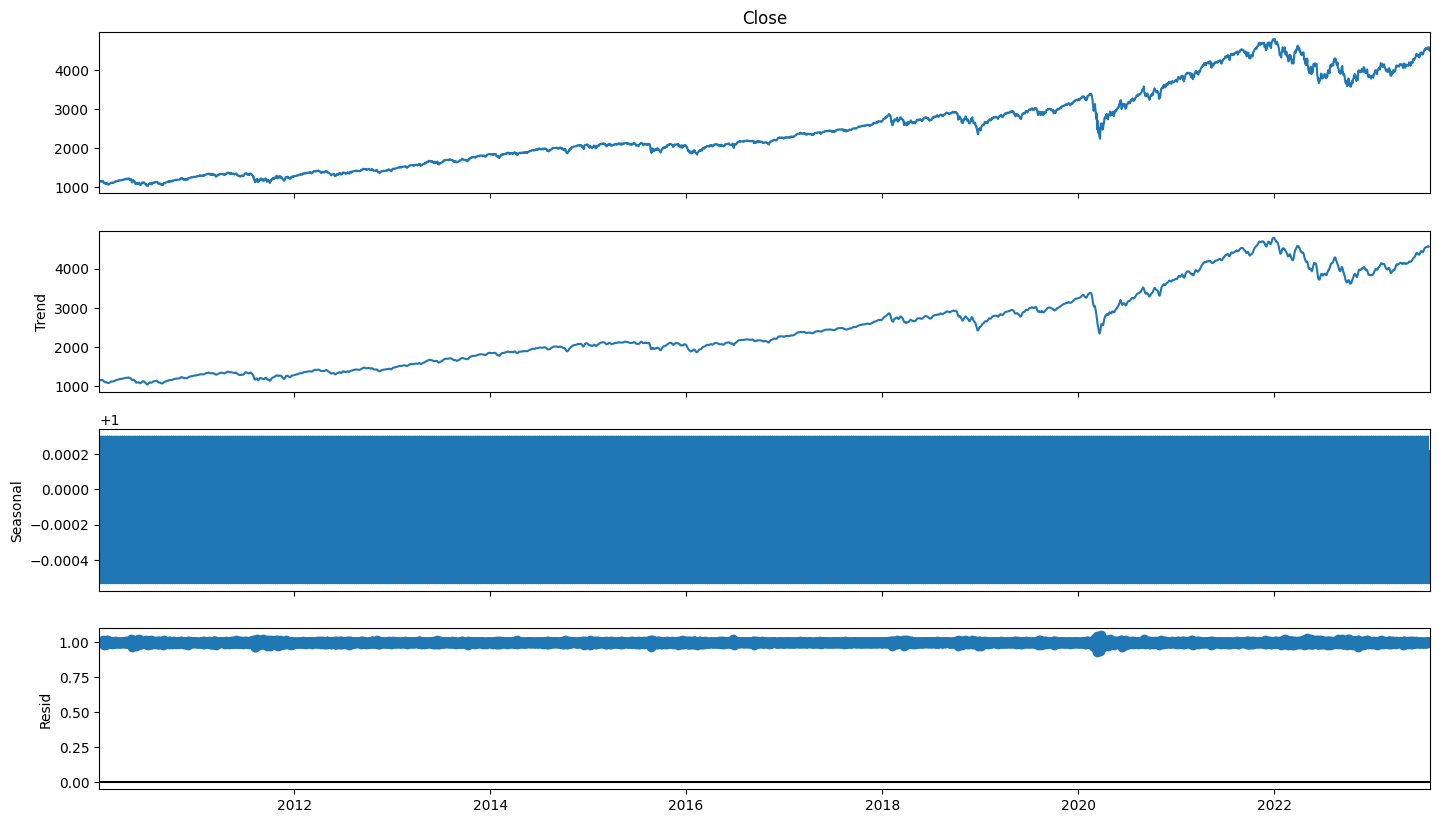

In [134]:
result = seasonal_decompose(df_c, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Autocorrelation analysis

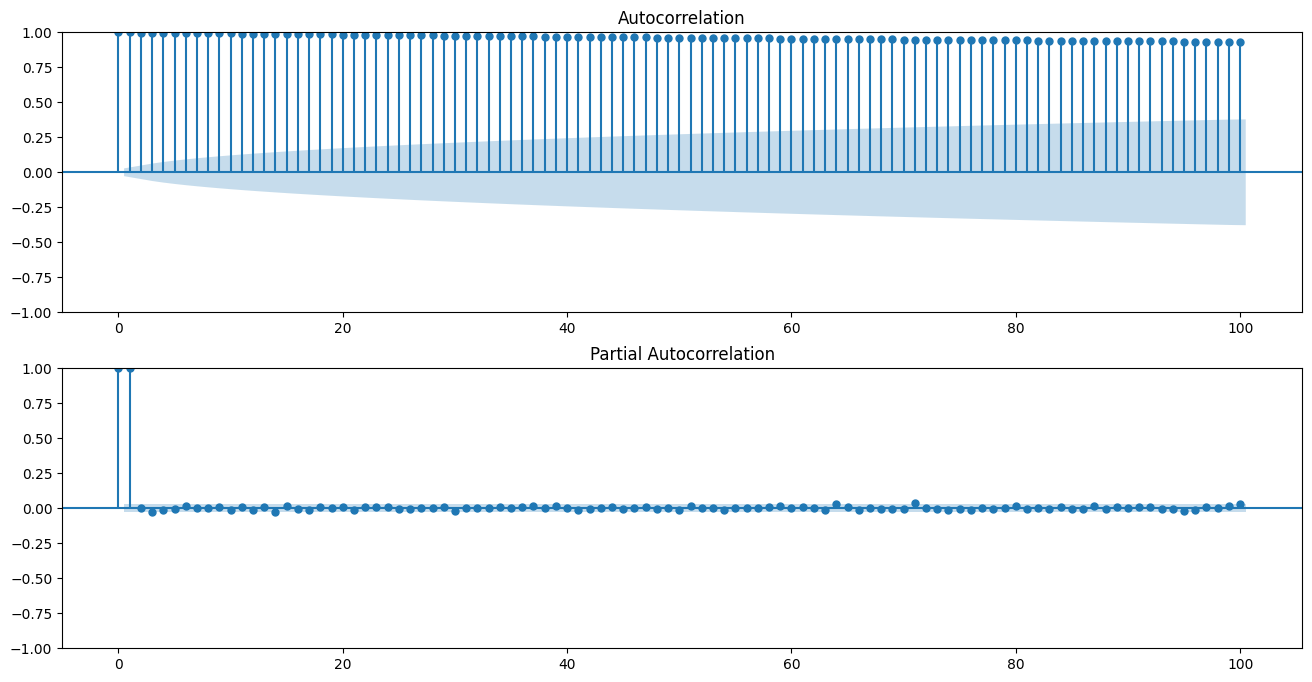

In [135]:
"""
Autocorrelation Function (ACF): P = periods to lag for 
(e.g.if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation)
Partial Autocorrelation Function (PACF): D = number of differencing transformations required to make the ts stationary
In an ARIMA model we make a time series stationary(i.e. without trend or seasonality) using differencing transformations.
Differencing transformations are the differences between consecutive observations.
"""

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df_close, lags=100, ax=ax[0])
plot_pacf(df_close, lags=100, ax=ax[1])

plt.show()

<Axes: xlabel='Date'>

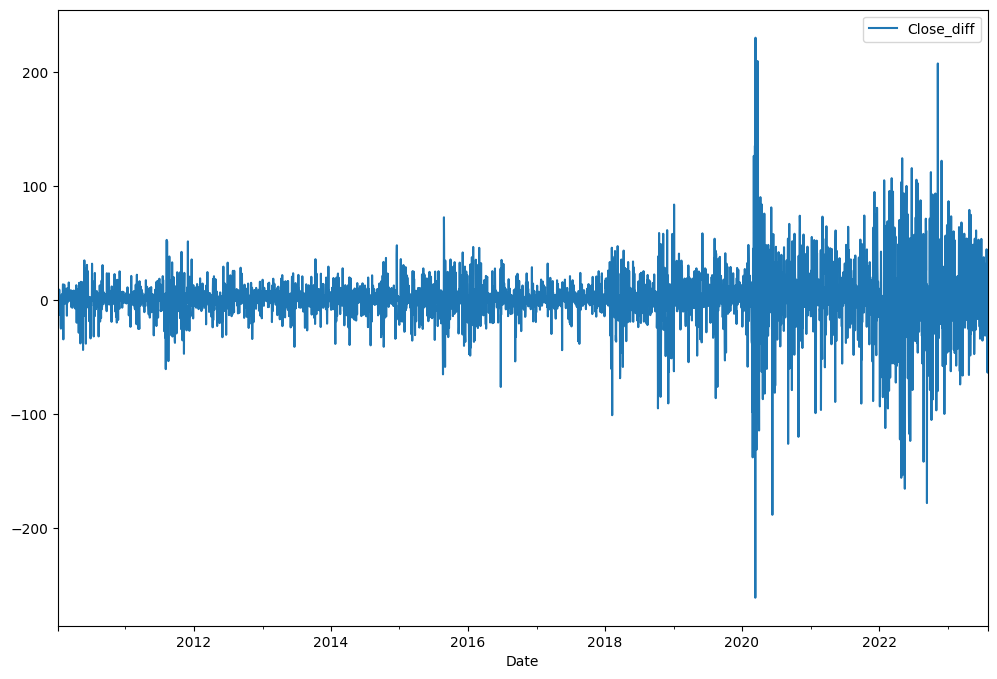

In [136]:
ts_diff = pd.DataFrame(np.diff(df_close.Close), index=df_close.index[1:])
ts_diff.columns = ['Close_diff']
ts_diff.plot(figsize=(12, 8))

## Train-test split

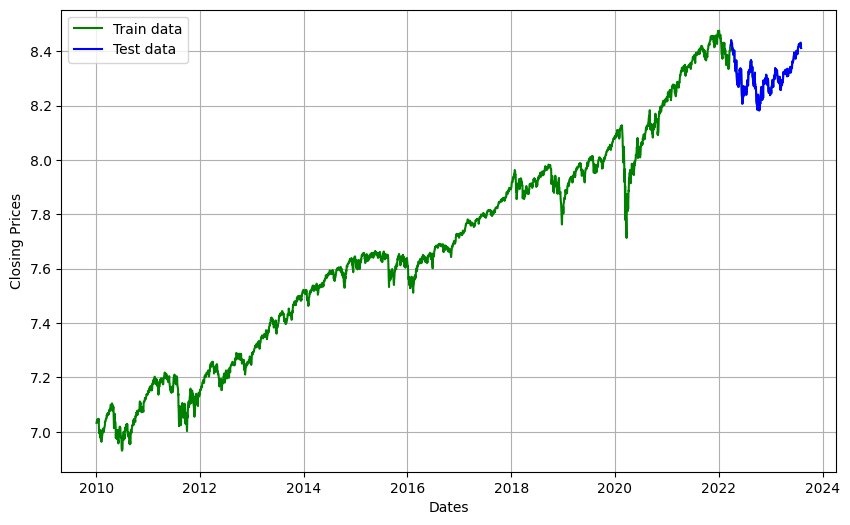

In [137]:
#split data into train and training set
train_data, test_data = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## ARIMA Model

In [138]:
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)
print(model_autoARIMA.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30862.734, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=2.12 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=3601.989, Time=4.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-30142.976, Time=1.53 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-30156.349, Time=2.76 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-30127.300, Time=3.04 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-30117.550, Time=4.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.65 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.95 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.97 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=3.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf,

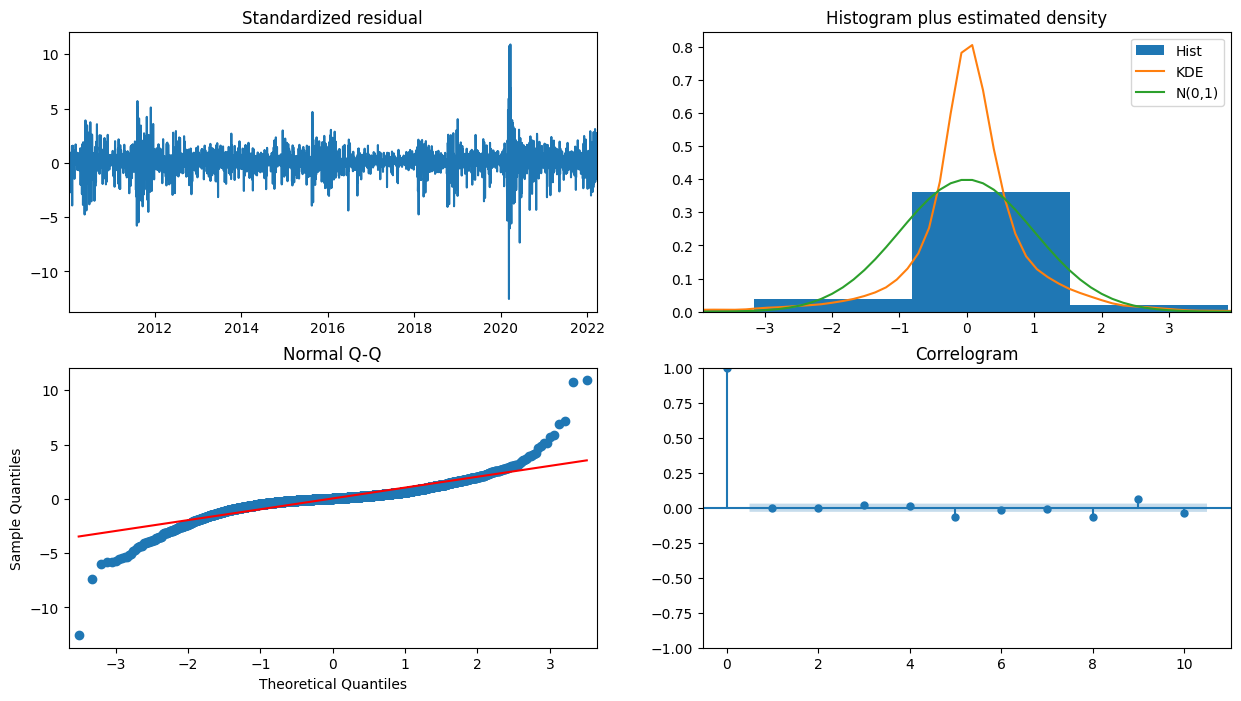

In [139]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [140]:
"""
The ARIMA (Autoregressive Integrated Moving Average) model is a generalization of an autoregressive moving average (ARMA) model.
The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged values,
the MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past,
the I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values 
(and this differencing process may have been performed more than once in order to achieve stationarity).

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, 
p is the order (number of time lags) of the autoregressive model, 
d is the degree of differencing (the number of times the data have had past values subtracted to achieve stationarity), 
and q is the order of the moving-average model. 

Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, 
and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model.

When two out of the three terms are zeros, the model may be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model.
For example, ARIMA(1,0,0) is AR(1), ARIMA(0,1,0) is I(1), and ARIMA(0,0,1) is MA(1).

Equation:
    y(t) = c + phi(1)*y(t-1) + ... + phi(p)*y(t-p) + theta(1)*e(t-1) + ... + theta(q)*e(t-q) + e(t)
where e(t) is white noise with mean zero and variance sigma^2,
c is a constant, phi(1), ..., phi(p) are the parameters of the autoregressive part of the model,
theta(1), ..., theta(q) are the parameters of the moving average part.

"""
model = ARIMA(train_data, order=model_autoARIMA.get_params().get('order'))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4464
Model:                 ARIMA(1, 0, 2)   Log Likelihood               15085.067
Date:                Fri, 04 Aug 2023   AIC                         -30160.135
Time:                        09:46:30   BIC                         -30128.116
Sample:                    01-04-2010   HQIC                        -30148.848
                         - 03-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6626      0.584     13.127      0.000       6.518       8.807
ar.L1          0.9999      0.000   3277.776      0.000       0.999       1.001
ma.L1         -0.0225      0.005     -4.532      0.0

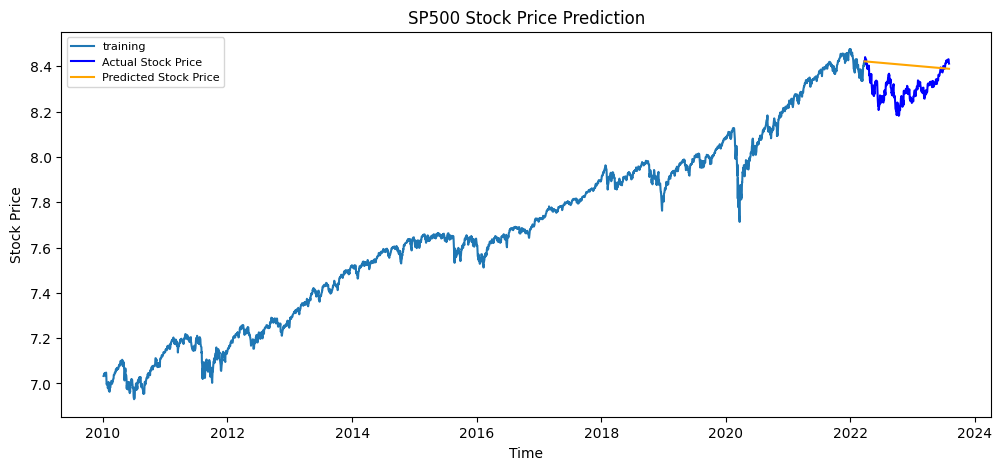

In [141]:
# Forecast
fc = fitted.forecast(len(test_data))
fc_series = pd.Series(fc, index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('SP500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Iterated forecasting

c:\Users\bergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

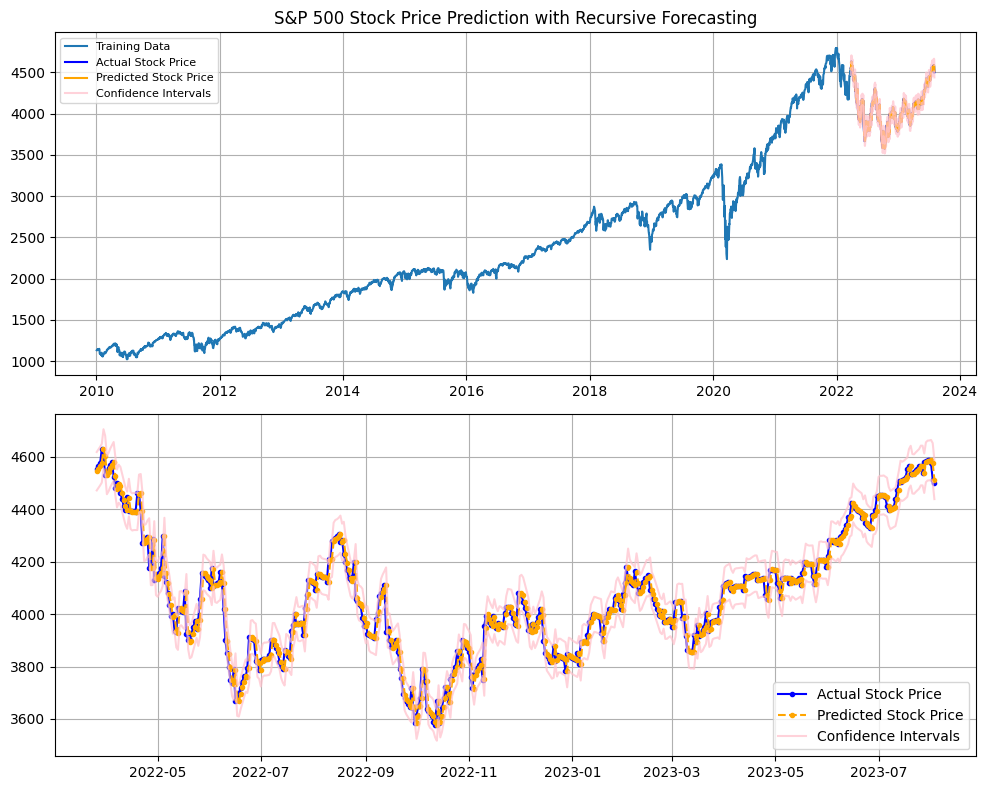

In [143]:
# Split data into train and test sets
train_data, test_data = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

# Initialize an empty list to store forecasted values
forecast_values = []
lower_conf_int = []
upper_conf_int = []

# Train ARIMA model on the train_data
model = ARIMA(train_data, order=model_autoARIMA.get_params().get('order'))
fitted = model.fit()

# Loop through the test data to make recursive forecasts
for i in range(len(test_data)):
    # Forecast one step ahead
    fc = fitted.forecast(steps=1)
    forecast_values.append(fc[0])  # Append the forecasted value to the list
    
    forecast_result = fitted.get_forecast(steps=1).summary_frame()  # Get the confidence interval
    lower_conf_int.append(forecast_result["mean_ci_lower"])
    upper_conf_int.append(forecast_result["mean_ci_upper"])  

    # Add the latest true observation to the train_data for the next iteration
    train_data = pd.concat([train_data, test_data[i:i+1]])

    # Update the model with the latest available data
    model = ARIMA(train_data, order=model_autoARIMA.get_params().get('order'))
    fitted = model.fit()

# Convert the forecasted log values back to original scale (inverse log transform)
forecast_values = np.exp(forecast_values)
lower_conf_int = np.exp(lower_conf_int)
upper_conf_int = np.exp(upper_conf_int)

# Create date range for forecast
forecast_dates = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='D')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual data, forecast, and confidence intervals
ax1.plot(np.exp(train_data), label='Training Data')
ax1.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
ax1.plot(forecast_dates, forecast_values, color='orange', label='Predicted Stock Price')
ax1.plot(forecast_dates, upper_conf_int, color='pink', alpha=0.7, label='Confidence Intervals')
ax1.plot(forecast_dates, lower_conf_int, color='pink', alpha=0.7)
ax1.set_title('S&P 500 Stock Price Prediction with Recursive Forecasting')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True)


# Plot Standard Deviation on the second subplot
ax2.plot(np.exp(test_data), color='blue', marker='.', label='Actual Stock Price')
ax2.plot(forecast_dates, forecast_values, ls ='--', marker='.', color='orange', label='Predicted Stock Price')
ax2.plot(forecast_dates, upper_conf_int, color='pink', alpha=0.7, label='Confidence Intervals')
ax2.plot(forecast_dates, lower_conf_int, color='pink', alpha=0.7)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [144]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
        y_true (array-like): Array of true values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: Mean Absolute Percentage Error (MAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(np.exp(test_data), forecast_values)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 6.46%


## Comparison with Multivariate Linear Regression (polynomial degree 2 and 2 lags as predictors)

In [205]:
%pip install stats

                                              0.0/127.6 kB ? eta -:--:--
     -------------------------------------- 127.6/127.6 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24297 sha256=36f4fa49174e3c47c56ac7a89aa469989778aa71f1602565f093e31cfbf2ea54
  Stored in directory: c:\users\bergi\appdata\local\pip\cache\wheels\57\7d\91\f1d0158783f74ab6ad725b00aa6a2c6e976cea652eb72616c6
Successfully built stats
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


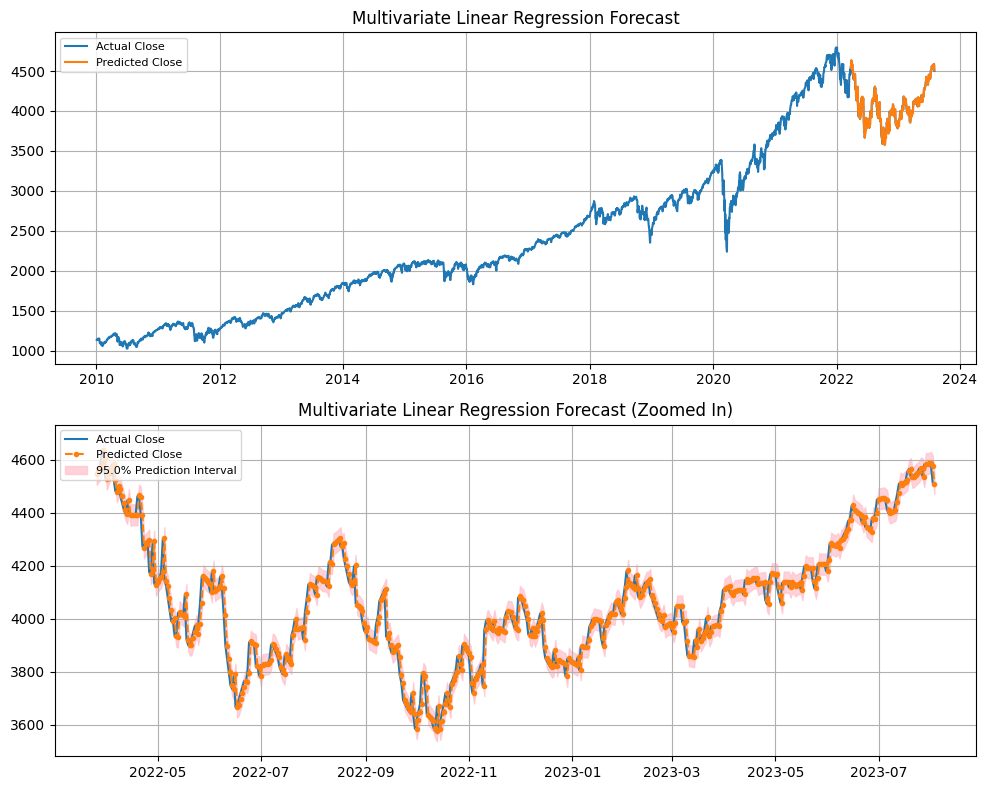

In [228]:
import scipy.stats as stats
# Set the number of periods to predict into the future
num_periods = len(df_close) - len(df_close[:int(len(df_close) * 0.9)])

# Split data into train and test sets
train_data, test_data = df_close[:-num_periods], df_close[-num_periods:]

# Initialize an empty list to store forecasted values
forecast_values = []

# Create lag features for each variable
def create_lag_features(data, lag):
    lag_data = pd.DataFrame(index=data.index)
    for col in data.columns:
        for i in range(1, lag + 1):
            lag_data[f"{col}_lag_{i}"] = data[col].shift(i)
    return lag_data.dropna()

# Choose an appropriate lag value
lag = 2

# Create lag features for both training and test data
X_train = create_lag_features(train_data, lag)
X_test = create_lag_features(pd.concat([train_data[-lag:], test_data]), lag)
y_train = train_data[lag:]

# Fit the linear regression model with polynomial features and regularization
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(X_train, y_train)

# Forecast the future values
forecast_values = model.predict(X_test)

# Calculate residuals
residuals = y_train - model.predict(X_train)

# Estimate prediction intervals
alpha = 0.05  # Significance level
z_critical = np.abs(stats.norm.ppf(alpha / 2))
std_residuals = np.std(residuals)
prediction_intervals = z_critical * std_residuals

# Convert the forecasted values to a DataFrame
forecast_df = pd.DataFrame(forecast_values, columns=df_close.columns)

# Create date range for forecast
forecast_dates = pd.date_range(start=test_data.index[0], periods=num_periods, freq='D')

# Plot the actual data and forecasted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(df_close.index, df_close, label=f'Actual Close')
ax1.plot(forecast_dates, forecast_df, label=f'Predicted Close')
ax1.set_title('Multivariate Linear Regression Forecast')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True)

ax2.plot(test_data.index, test_data, label=f'Actual Close')
ax2.plot(forecast_dates, forecast_df, label=f'Predicted Close', linestyle='--', marker='.')
ax2.fill_between(
        forecast_dates,
        forecast_df.Close - prediction_intervals[0],
        forecast_df.Close + prediction_intervals[0],
        color='pink', alpha=0.7, label=f'{100-alpha*100}% Prediction Interval'
    )
ax2.set_title('Multivariate Linear Regression Forecast (Zoomed In)')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True)

plt.tight_layout()
plt.show()

In [203]:
mape = mean_absolute_percentage_error(test_data, forecast_df.Close)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 6.46%
